# Tiny Stories | Single Layer Bilinear Model
This notebook generates the figures for the paper "Weight-based Decomposition: A Case for Bilinear MLPs"

# Setup

In [1]:
!pip install einops
!pip install jaxtyping
!git clone https://github.com/tdooms/bilinear-interp.git
!pip install transformers
!pip install wandb
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install transformer_lens
!pip install nnsight

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:00
Cloning into 'bilinear-interp'...
remote: Enumerating objects: 1286, done.
remote: Counting objects: 100% (544/544), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 1286 (delta 297), reused 480 (delta 253), pack-reused 742
Receiving objects: 100% (1286/1286), 214.49 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (710/710), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.8 MB/s eta 0:

In [2]:
%cd /content/bilinear-interp

/content/bilinear-interp


In [3]:
# !git pull

In [4]:
%load_ext autoreload
%autoreload 2

from language import Transformer, Config
import plotly.express as px
import torch
import pandas as pd
from einops import *
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

torch.set_grad_enabled(False)

# name = "tdooms/TinyStories-1-512-i"
n_layer = 1
d_model = 1024
modifier = 'i5n'

# config = Config.from_pretrained(name)
model = Transformer.from_pretrained(n_layer=n_layer, d_model=d_model, modifier=modifier).cpu()
vocab = model.vocab

# color = dict(color_continuous_midpoint=0, color_continuous_scale="RdBu")
# facet = dict(height=200 * config.n_layer + 200, facet_col=0, facet_col_wrap=config.n_head)

# def set_facet_labels(fig):
#     for annotation in fig.layout.annotations:
#         facet = int(annotation.text.split("=")[-1])
#         annotation.update(text=f"Head {facet // config.n_head}.{facet % config.n_head}")
#     return fig

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/87.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [5]:
def style_df(df):
    cols = (df.dtypes == 'float32').values
    vals = df.iloc[:,cols]
    max = vals.max().max()
    min = vals.min().min()
    vmax = np.max([max, np.abs(min)])

    cm = sns.color_palette("RdBu", as_cmap=True)
    df = df.style.background_gradient(cmap=cm, vmin=-vmax, vmax=vmax)
    return df

def display_OVE_vec(vec):
    # vec: [d_head+1 vocab]
    df_list = []
    head_names = ['Direct'] + [f"Head {head}" for head in range(vec.shape[0]-1)]
    for head, name in enumerate(head_names):
        df = vocab.describe(vec[head], [name])
        if head == 0:
            df = df.rename(columns={'value': f'Value'})
        else:
            df = df.rename(columns={'value': f'Value {head-1}'})
        df_list.append(df)

    df = pd.concat(df_list, axis=1)
    df = style_df(df)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)

def describe(tensor, k=10, axes=None, value=None):
    hig = torch.topk(tensor.flatten(), k=k, largest=True)
    low = torch.topk(tensor.flatten(), k=k, largest=False)

    values = torch.cat([hig.values, low.values.flip(0)])
    indices = torch.cat([hig.indices, low.indices.flip(0)])

    dims = torch.unravel_index(indices, tensor.size())
    if axes is None:
        axes = [f"Dim {i}" for i in range(len(dims))]
    if value is None:
        value = 'Value'
    data = {axis:v for axis,v in zip(axes, dims)}
    return pd.DataFrame({**data, value:values})

def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=True, scale=None) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / np.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight

In [6]:
model.config

Config {
  "_name_or_path": "tdooms/TinyStories-1-1024-i5n",
  "architectures": [
    "Transformer"
  ],
  "attn_dropout": 0.0,
  "d_hidden": 3072,
  "d_model": 1024,
  "embed_dropout": 0.0,
  "mlp": "blp",
  "mlp_bias": false,
  "mlp_dropout": 0.0,
  "modifier": null,
  "n_ctx": 256,
  "n_head": 8,
  "n_layer": 1,
  "n_vocab": 4096,
  "noise": 0.33,
  "norm_bias": false,
  "normalization": null,
  "resid_dropout": 0.0,
  "torch_dtype": "float32",
  "transformers_version": "4.41.1"
}

# Eigenvectors for specific output tokens

In [7]:
W_u = model.w_u.detach()
W_e = model.w_e.detach()
B = model.b.detach()[0]

OV = model.ov[0].detach()
OVE = OV @ W_e
OVE = torch.cat([W_e.unsqueeze(0), OVE], dim=0) #head, d_model, vocab

In [8]:
token = 'swim'
comparison_tokens = ['run', 'climb', 'eat', 'see', 'smell', 'walk', 'fly', 'sit', 'sleep']

tok_idx = vocab[token]
comp_tok_ids = vocab[comparison_tokens]

# Unembed = W_u[tok_idx]
Unembed = W_u[tok_idx] - W_u[comp_tok_ids].mean(dim=0)

Q = einsum(B, Unembed, "out ..., out -> ...")
eigvals, eigvecs = torch.linalg.eigh(Q)

Text(0.5, 1.0, 'Eigenvalues for "swim" interaction matrix')

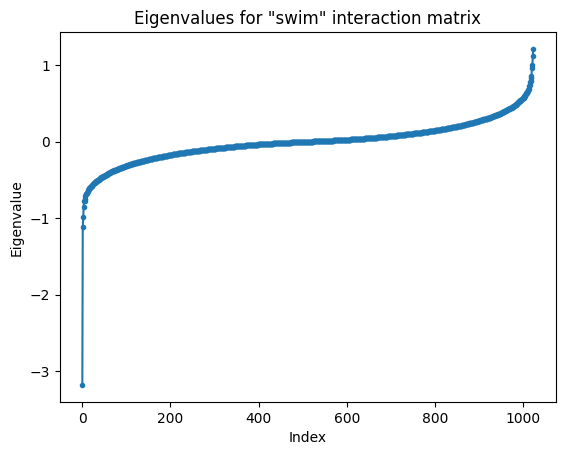

In [9]:
plt.plot(eigvals, '.-')
plt.ylabel('Eigenvalue')
plt.xlabel('Index')
plt.title(f'Eigenvalues for "{token}" interaction matrix')

## Virtual Token Basis
Virtual tokens are the input tokens that are passed through the embedding layer and one attention head or skips attention (direct).

In [10]:
eig_idx = -1
eigvec = eigvecs[:,eig_idx]
eigvec_toks = einsum(eigvec, OVE, "d_model, head d_model tok -> head tok")

display_OVE_vec(eigvec_toks)

,Direct,Value,Head 0,Value 0,Head 1,Value 1,Head 2,Value 2,Head 3,Value 3,Head 4,Value 4,Head 5,Value 5,Head 6,Value 6,Head 7,Value 7
0,[BOS],0.773672,tree,1.565342,slide,0.381307,outside,0.334178,tears,0.409095,upon,0.418710,things,1.053617,even,0.533980,wr,0.472482
1,un,0.206154,climb,1.099573,ladder,0.254467,leaves,0.333372,came,0.355183,trees,0.372680,rode,0.931213,upon,0.470841,sl,0.443548
2,birds,0.188057,bush,0.859344,##ama,0.246650,branch,0.312141,cheer,0.350230,apples,0.352665,tree,0.903428,sl,0.469062,t,0.434504
3,diam,0.183065,chim,0.810877,zoo,0.244009,hears,0.309078,hear,0.337946,tree,0.349786,tower,0.897902,sometimes,0.447572,cr,0.424453
4,waves,0.181028,high,0.806614,tree,0.239617,bark,0.305820,voice,0.326133,berries,0.335625,land,0.872682,splash,0.430256,store,0.359683
5,ext,0.179537,waff,0.800846,fence,0.237695,flies,0.304136,eyes,0.318521,this,0.328247,hide,0.870714,cows,0.414560,not,0.353726
6,thunder,0.172519,peach,0.782691,slides,0.232869,flying,0.298224,##gs,0.314452,sun,0.326667,fort,0.849264,splashed,0.409129,away,0.349100
7,elev,0.166518,nap,0.780212,store,0.232147,fell,0.296311,sound,0.312521,kn,0.322835,around,0.843738,swim,0.396624,un,0.333258
8,con,0.165495,apples,0.721559,couch,0.230311,fall,0.292509,##cks,0.307076,clouds,0.303061,way,0.838343,lions,0.392301,stu,0.333201
9,sto,0.164302,climbed,0.716044,swings,0.229212,shakes,0.291411,##at,0.298388,forest,0.302593,ceiling,0.827392,flo,0.392156,shr,0.332738


In [11]:
eig_idx = 2
eigvec = eigvecs[:,eig_idx]
eigvec_toks = einsum(eigvec, OVE, "d_model, head d_model tok -> head tok")

display_OVE_vec(eigvec_toks)

,Direct,Value,Head 0,Value 0,Head 1,Value 1,Head 2,Value 2,Head 3,Value 3,Head 4,Value 4,Head 5,Value 5,Head 6,Value 6,Head 7,Value 7
0,pan,0.342760,swim,1.930022,spent,0.246200,makes,0.401325,heart,0.322091,pre,0.433146,jump,1.323911,s,0.455631,comes,0.389666
1,cat,0.310929,jump,1.697943,ret,0.244823,jumps,0.390171,were,0.309528,##p,0.392326,way,1.288017,at,0.437314,came,0.386562
2,un,0.308956,dance,1.473226,un,0.206831,runs,0.368831,been,0.308843,shoes,0.390327,run,1.137683,sometimes,0.367943,cries,0.316429
3,dog,0.305871,jumps,1.388191,spend,0.202332,saw,0.362941,big,0.306592,re,0.366296,high,1.105124,##ither,0.362448,angry,0.298424
4,gra,0.279307,swimming,1.326536,feel,0.200481,landed,0.343000,was,0.306091,dog,0.359426,play,1.102312,each,0.353649,cry,0.290930
5,lu,0.268724,jumping,1.251048,wagged,0.199820,sees,0.334955,wide,0.292208,wallet,0.350975,loud,1.099771,bush,0.348959,gr,0.288496
6,##br,0.263765,dancing,1.147454,just,0.195034,jumped,0.330488,being,0.288076,are,0.347835,too,1.073740,un,0.342886,sque,0.288208
7,ad,0.259281,##o,1.135612,matter,0.194673,hopped,0.324865,be,0.278034,ener,0.343701,climb,1.047038,tree,0.337622,help,0.288179
8,pup,0.259106,skip,1.133215,had,0.193257,run,0.322024,became,0.275423,ball,0.342576,reach,1.038800,head,0.335038,pain,0.280970
9,[BOS],0.258736,dive,1.111960,cast,0.192124,made,0.306991,reached,0.274888,##les,0.330074,jumping,1.037224,one,0.320990,hurt,0.279660


## Top Activating Inputs

In [12]:
from nnsight import LanguageModel
nnsight_model = LanguageModel(model, tokenizer=model.tokenizer)

In [13]:
def print_attn_weighted_text(data, batch_idx, pos_idx, eigvec, eigval, start_toks = 15, end_toks = 3):
    start = max(pos_idx-start_toks, 0)
    end = pos_idx + end_toks

    input_ids = data['input_ids'][batch_idx]
    with nnsight_model.trace(input_ids) as trace:
        attn_input = nnsight_model.transformer.h[0].attn.input[0][0].save()
        qkv = nnsight_model.transformer.h[0].attn.qkv.output.save()
        o = nnsight_model.transformer.h[0].attn.o.output.save()
        mlp_input = nnsight_model.transformer.h[0].mlp.input[0][0].save()

    # get attention weighted contributions to pos_idx
    q, k, v = rearrange(qkv, 'batch seq (n_proj n_head d_head) -> n_proj batch n_head seq d_head', n_proj=3, n_head=model.config.n_head).unbind(dim=0)
    q, k = model.transformer.h[0].attn.rotary(q,k, q.device)
    attn_weight = scaled_dot_product_attention(q, k, v)
    z = attn_weight[:,:,pos_idx].unsqueeze(-1) * v    #get attn-weighted value vecs that contribute to pos_idx
    z = rearrange(z, 'batch n_head seq d_head -> batch seq (n_head d_head)')
    o = model.transformer.h[0].attn.o(z)

    # add direct path contribution
    o[:, pos_idx] += attn_input[:,pos_idx]

    # dot product with eigvec
    sims = o[0] @ eigvec
    max_sim = sims.abs().max()
    sign = torch.sign(sims.sum())
    sims = sign * sims

    # get color rgb
    colors = 255 * plt.cm.RdBu((sims[start:pos_idx+1]+max_sim)/ (2*max_sim))
    start_text = model.vocab[data['input_ids'][batch_idx, start:pos_idx+1]]
    end_text = model.vocab[data['input_ids'][batch_idx, pos_idx+1:end+1]]

    # compute brightness/luminance in order to change text color for dark backgrounds
    linear_colors = colors/255
    linear_colors[linear_colors <= 0.04045] = linear_colors[linear_colors <= 0.04045]/12.92
    linear_colors[linear_colors > 0.04045] = ((linear_colors[linear_colors > 0.04045] + 0.055) / 1.055) ** 2
    luminance=0.2126*linear_colors[:,0]+0.7152 * linear_colors[:,1]+0.0722 * linear_colors[:,2]
    luminance[luminance <= 0.008856] = 903.3 * luminance[luminance <= 0.008856]
    luminance[luminance > 0.008856] = luminance[luminance > 0.008856] ** (1/3) * 116 - 16

    color_text = ["\033[" + ("37;" if luminance[i] < 60 else "30;") + f"48;2;{int(colors[i,0])};{int(colors[i,1])};{int(colors[i,2])}m" + \
                (start_text[i] if i < len(start_text)-1 else "\033[1m[" + start_text[i]+"]\033[0m") for i in range(len(start_text))
                ]

    act = eigval * (sims.sum())**2
    print(f"Activation: {act:.2f} | " + ' '.join(color_text+end_text))

In [14]:
data = model.dataset(collated = True, tokenized = True, split = 'validation')

Generating train split:   0%|          | 0/1798254 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16384 [00:00<?, ? examples/s]

In [15]:
eig_idxs = torch.tensor(list(range(20)) + list(range(-20,0)))

eig_acts = []

batch_size = 1000
for i in range(0, data['input_ids'].shape[0], batch_size):
    input_ids = data['input_ids'][i:i+batch_size]
    with nnsight_model.trace(input_ids) as trace:
        mlp_input = nnsight_model.transformer.h[0].mlp.input[0][0].save()
    sims = einsum(mlp_input, eigvecs[:,eig_idxs], "batch pos d_model, d_model eig -> batch pos eig")
    acts = (sims**2)
    eig_acts.append(acts)

eig_acts = torch.cat(eig_acts, dim=0)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [17]:
idxs = [-1, -2, -3, -4, 0, 1, 2, 3]
k = 200

topk = rearrange(eig_acts[:,:,idxs], "batch pos eig -> (batch pos) eig").topk(dim=0, k = k)
batch_idxs, pos_idxs = torch.unravel_index(topk.indices, eig_acts.shape[:2])

for idx in idxs:
    topk = rearrange(eig_acts[:,:,idx], "batch pos -> (batch pos)").topk(dim=0, k = k)
    batch_idxs, pos_idxs = torch.unravel_index(topk.indices, eig_acts.shape[:2])

    eigvec = eigvecs[:,eig_idxs[idx]]
    eigval = eigvals[eig_idxs[idx]]
    print(f'\nEig Idx: {idx} for "{token}"\n')

    batches_used = set()
    count = 0
    for batch_idx, pos_idx in zip(batch_idxs, pos_idxs):
        if batch_idx.item() in batches_used:
            continue
        else:
            count +=1

        if count > 8:
            break
        print_attn_weighted_text(data, batch_idx, pos_idx, eigvec, eigval, start_toks = 20)
        batches_used.add(batch_idx.item())




Eig Idx: -1 for "swim"

Activation: 7.89 | the pool and had lots of fun . the water was still smooth and cool , and they were happy [to] share . [EOS]
Activation: 7.21 | swim with me ? " asked gi ##lly . fin smiled and said , " yes , i would love [to] swim with you
Activation: 7.20 | big sister , mia . mia had a li ##ce ##n ##se to swim , because she was very good [at] it . lily
Activation: 7.00 | [BOS] lily liked to swim in the pool with her mom and dad . she [wore] a pink swim
Activation: 6.89 | sad but it was time to go home . he got out of the water and changed back into his [ordinary] clothes . he
Activation: 6.82 | one day , he went to the pool with his mom . the pool seemed perfect to timmy . he [jumped] in and splashed
Activation: 6.76 | there was a big pool . inside the pool was a fish . his name was tommy . tommy loved [to] dive deep in
Activation: 6.66 | the pool . " look , lily , i can swim like a fish ! " tom says . he [jumps] into the water

Eig Idx: -2 for "swim"

Activ